In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [2]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

In [54]:
api = ApiFetcher(starting_year=2019, ending_year=2025)
df = api.get_dataframe('leaguegamelog', all=True)


In [59]:
import pandas as pd

def build_team_ratings(api_df, alpha=0.1):
    # sort games chronologically
    df = api_df.sort_values("date").reset_index(drop=True)
    
    # dicts for storing running ratings - initialize at 100
    off_ratings = {}
    def_ratings = {}
    
    # output records
    records = []
    
    for _, row in df.iterrows():
        game_id = row["game_id"]
        date = row["date"]
        home_id = row["home_team_id"]
        away_id = row["away_team_id"]
        
        # GET RATINGS BEFORE THE GAME (or default to 100 if first game)
        home_off_before = off_ratings.get(home_id, 100)
        home_def_before = def_ratings.get(home_id, 100)
        away_off_before = off_ratings.get(away_id, 100)
        away_def_before = def_ratings.get(away_id, 100)
        
        # Calculate home advantage BEFORE the game
        home_advantage = home_off_before - away_off_before
        
        # Store the record with PRE-GAME ratings
        records.append({
            "date": date,
            "game_id": game_id,
            "home_team_id": home_id,
            "away_team_id": away_id,
            "home_off_rating": home_off_before,
            "home_def_rating": home_def_before,
            "away_off_rating": away_off_before,
            "away_def_rating": away_def_before,
            "home_advantage": home_advantage
        })
        
        # NOW UPDATE RATINGS based on game results
        # possessions for each team using new formula
        home_poss = 0.96 * (row["home_fga"] + row["home_tov"] + 0.44 * row["home_fta"] - row["home_oreb"])
        away_poss = 0.96 * (row["away_fga"] + row["away_tov"] + 0.44 * row["away_fta"] - row["away_oreb"])
        
        # ratings from this game
        home_off_game = 100 * row["home_pts"] / home_poss if home_poss > 0 else 0
        home_def_game = 100 * row["away_pts"] / away_poss if away_poss > 0 else 0
        away_off_game = 100 * row["away_pts"] / away_poss if away_poss > 0 else 0
        away_def_game = 100 * row["home_pts"] / home_poss if home_poss > 0 else 0
        
        # update ratings using exponential moving average
        home_off = (1 - alpha) * home_off_before + alpha * home_off_game
        home_def = (1 - alpha) * home_def_before + alpha * home_def_game
        away_off = (1 - alpha) * away_off_before + alpha * away_off_game
        away_def = (1 - alpha) * away_def_before + alpha * away_def_game
        
        # save updated ratings for next game
        off_ratings[home_id] = home_off
        def_ratings[home_id] = home_def
        off_ratings[away_id] = away_off
        def_ratings[away_id] = away_def
    
    return pd.DataFrame(records)

In [62]:
        def print_game_stats_for_manual_calc(api_df, team_id, game_num):
            """
            Print raw stats for a specific team's game so you can manually calculate ratings
            """
            # Sort chronologically
            df = api_df.sort_values("date").reset_index(drop=True)
            
            # Get games for this team
            team_games = df[(df['home_team_id'] == team_id) | (df['away_team_id'] == team_id)].reset_index(drop=True)
            
            if game_num >= len(team_games):
                print(f"Error: Team {team_id} only has {len(team_games)} games")
                return
            
            game = team_games.iloc[game_num]
            is_home = game['home_team_id'] == team_id
            
            print(f"\n{'='*60}")
            print(f"Team {team_id} - Game {game_num}")
            print(f"{'='*60}")
            print(f"Date: {game['date']}")
            print(f"Game ID: {game['game_id']}")
            print(f"Location: {'HOME' if is_home else 'AWAY'}")
            print(f"\nRAW STATS:")
            print(f"  Home Team ID: {game['home_team_id']}")
            print(f"  Away Team ID: {game['away_team_id']}")
            print(f"\n  Home Score: {game['home_pts']}")
            print(f"  Away Score: {game['away_pts']}")
            print(f"\n  Home FGA: {game['home_fga']}")
            print(f"  Home OREB: {game['home_oreb']}")
            print(f"  Home TOV: {game['home_tov']}")
            print(f"  Home FTA: {game['home_fta']}")
            print(f"\n  Away FGA: {game['away_fga']}")
            print(f"  Away OREB: {game['away_oreb']}")
            print(f"  Away TOV: {game['away_tov']}")
            print(f"  Away FTA: {game['away_fta']}")
            
            # Calculate possessions using NEW formula
            home_poss = 0.96 * (game["home_fga"] + game["home_tov"] + 0.44 * game["home_fta"] - game["home_oreb"])
            away_poss = 0.96 * (game["away_fga"] + game["away_tov"] + 0.44 * game["away_fta"] - game["away_oreb"])
            
            print(f"\nCALCULATED POSSESSIONS:")
            print(f"  Home Poss = 0.96 * ({game['home_fga']} + {game['home_tov']} + 0.44*{game['home_fta']} - {game['home_oreb']}) = {home_poss:.2f}")
            print(f"  Away Poss = 0.96 * ({game['away_fga']} + {game['away_tov']} + 0.44*{game['away_fta']} - {game['away_oreb']}) = {away_poss:.2f}")
            
            print(f"\nFOR MANUAL CALCULATION (alpha=0.1):")
            print(f"  Rating BEFORE this game: 100 (if game 0) or previous game's updated rating")
            if is_home:
                print(f"  Team {team_id} Offensive Rating This Game = 100 * {game['home_pts']} / {home_poss:.2f} = {100 * game['home_pts'] / home_poss:.4f}")
                print(f"  Team {team_id} Defensive Rating This Game = 100 * {game['away_pts']} / {away_poss:.2f} = {100 * game['away_pts'] / away_poss:.4f}")
            else:
                print(f"  Team {team_id} Offensive Rating This Game = 100 * {game['away_pts']} / {away_poss:.2f} = {100 * game['away_pts'] / away_poss:.4f}")
                print(f"  Team {team_id} Defensive Rating This Game = 100 * {game['home_pts']} / {home_poss:.2f} = {100 * game['home_pts'] / home_poss:.4f}")
            print(f"  Updated Rating = 0.9 * (previous rating) + 0.1 * (this game rating)")
            print(f"{'='*60}\n")

        # Usage:
        print_game_stats_for_manual_calc(df, team_id=1, game_num=1)
        print_game_stats_for_manual_calc(df, team_id=2, game_num=2)


Team 1 - Game 1
Date: 2019-10-25
Game ID: 0021900017
Location: HOME

RAW STATS:
  Home Team ID: 1
  Away Team ID: 27

  Home Score: 112
  Away Score: 106

  Home FGA: 109
  Home OREB: 21
  Home TOV: 10
  Home FTA: 16

  Away FGA: 78
  Away OREB: 5
  Away TOV: 23
  Away FTA: 17

CALCULATED POSSESSIONS:
  Home Poss = 0.96 * (109 + 10 + 0.44*16 - 21) = 100.84
  Away Poss = 0.96 * (78 + 23 + 0.44*17 - 5) = 99.34

FOR MANUAL CALCULATION (alpha=0.1):
  Rating BEFORE this game: 100 (if game 0) or previous game's updated rating
  Team 1 Offensive Rating This Game = 100 * 112 / 100.84 = 111.0688
  Team 1 Defensive Rating This Game = 100 * 106 / 99.34 = 106.7034
  Updated Rating = 0.9 * (previous rating) + 0.1 * (this game rating)


Team 2 - Game 2
Date: 2019-10-27
Game ID: 0021900037
Location: AWAY

RAW STATS:
  Home Team ID: 14
  Away Team ID: 2

  Home Score: 134
  Away Score: 133

  Home FGA: 103
  Home OREB: 8
  Home TOV: 12
  Home FTA: 25

  Away FGA: 101
  Away OREB: 11
  Away TOV: 17
  

In [ ]:
    # def sanity_check_team_progression(api_df, ratings_df, team_id=1, alpha=0.1):
    #     """
    #     Show the progression of ratings for a team across their first few games
    #     """
    #     print(f"\n{'='*80}")
    #     print(f"SANITY CHECK: Team {team_id} Progression (Games 0, 1, 2)")
    #     print(f"{'='*80}\n")
        
    #     # Get chronological games for this team
    #     df = api_df.sort_values("date").reset_index(drop=True)
    #     team_games = df[(df['home_team_id'] == team_id) | (df['away_team_id'] == team_id)].reset_index(drop=True)
        
    #     # Manually track ratings starting at 100
    #     off_rating = 100
    #     def_rating = 100
        
    #     # Process games 0, 1, 2
    #     for i in range(min(3, len(team_games))):
    #         game = team_games.iloc[i]
    #         is_home = game['home_team_id'] == team_id
            
    #         print(f"\n{'='*80}")
    #         print(f"GAME {i}:")
    #         print(f"{'='*80}")
    #         print(f"Date: {game['date']}")
    #         print(f"Game ID: {game['game_id']}")
    #         print(f"Location: {'HOME' if is_home else 'AWAY'}")
    #         print(f"Opponent: Team {game['away_team_id'] if is_home else game['home_team_id']}")
            
    #         print(f"\n>>> RATING BEFORE GAME {i}:")
    #         print(f"    Off Rating = {off_rating:.4f}")
    #         print(f"    Def Rating = {def_rating:.4f}")
            
    #         # Calculate possessions using new formula
    #         home_poss = 0.96 * (game["home_fga"] + game["home_tov"] + 0.44 * game["home_fta"] - game["home_oreb"])
    #         away_poss = 0.96 * (game["away_fga"] + game["away_tov"] + 0.44 * game["away_fta"] - game["away_oreb"])
            
    #         if is_home:
    #             team_poss = home_poss
    #             opp_poss = away_poss
    #             team_pts = game["home_pts"]
    #             opp_pts = game["away_pts"]
    #         else:
    #             team_poss = away_poss
    #             opp_poss = home_poss
    #             team_pts = game["away_pts"]
    #             opp_pts = game["home_pts"]
            
    #         print(f"\n>>> GAME STATS:")
    #         print(f"    Team Score: {team_pts}")
    #         print(f"    Opp Score: {opp_pts}")
    #         print(f"    Team Possessions: {team_poss:.2f}")
    #         print(f"    Opp Possessions: {opp_poss:.2f}")
            
    #         # Calculate game ratings
    #         off_game = 100 * team_pts / team_poss if team_poss > 0 else 0
    #         def_game = 100 * opp_pts / opp_poss if opp_poss > 0 else 0
            
    #         print(f"\n>>> GAME PERFORMANCE:")
    #         print(f"    Off Rating This Game = 100 * {team_pts} / {team_poss:.2f} = {off_game:.4f}")
    #         print(f"    Def Rating This Game = 100 * {opp_pts} / {opp_poss:.2f} = {def_game:.4f}")
            
    #         # Update ratings for next game
    #         new_off = (1 - alpha) * off_rating + alpha * off_game
    #         new_def = (1 - alpha) * def_rating + alpha * def_game
            
    #         print(f"\n>>> UPDATING RATINGS (for next game):")
    #         print(f"    New Off = (1 - {alpha}) * {off_rating:.4f} + {alpha} * {off_game:.4f}")
    #         print(f"            = {1-alpha} * {off_rating:.4f} + {alpha} * {off_game:.4f}")
    #         print(f"            = {(1-alpha) * off_rating:.4f} + {alpha * off_game:.4f}")
    #         print(f"            = {new_off:.4f}")
    #         print(f"    New Def = (1 - {alpha}) * {def_rating:.4f} + {alpha} * {def_game:.4f}")
    #         print(f"            = {1-alpha} * {def_rating:.4f} + {alpha} * {def_game:.4f}")
    #         print(f"            = {(1-alpha) * def_rating:.4f} + {alpha * def_game:.4f}")
    #         print(f"            = {new_def:.4f}")
            
    #         # Compare with ratings_df
    #         print(f"\n>>> COMPARISON WITH RATINGS_DF:")
    #         target_game_id = game['game_id']
    #         df_row = ratings_df[ratings_df['game_id'] == target_game_id].iloc[0]
            
    #         if is_home:
    #             df_off = df_row['home_off_rating']
    #             df_def = df_row['home_def_rating']
    #         else:
    #             df_off = df_row['away_off_rating']
    #             df_def = df_row['away_def_rating']
            
    #         print(f"    Manual Calculation (BEFORE game): Off={off_rating:.4f}, Def={def_rating:.4f}")
    #         print(f"    DataFrame Value:                   Off={df_off:.4f}, Def={df_def:.4f}")
    #         print(f"    Difference:                        Off={abs(off_rating - df_off):.8f}, Def={abs(def_rating - df_def):.8f}")
            
    #         if abs(off_rating - df_off) < 1e-6 and abs(def_rating - df_def) < 1e-6:
    #             print(f"    ✓ MATCH!")
    #         else:
    #             print(f"    ✗ MISMATCH!")
            
    #         # Update for next iteration
    #         off_rating = new_off
    #         def_rating = new_def
        
    #     print(f"\n{'='*80}\n")

    # # Usage:
    # ratings_df = build_team_ratings(df)
    # sanity_check_team_progression(df, ratings_df, team_id=1)


SANITY CHECK: Team 1 Progression (Games 0, 1, 2)


GAME 0:
Date: 2024-10-22
Game ID: 0022400061
Location: HOME
Opponent: Team 19

>>> RATING BEFORE GAME 0:
    Off Rating = 100.0000
    Def Rating = 100.0000

>>> GAME STATS:
    Team Score: 132
    Opp Score: 109
    Team Possessions: 87.86
    Opp Possessions: 88.36

>>> GAME PERFORMANCE:
    Off Rating This Game = 100 * 132 / 87.86 = 150.2404
    Def Rating This Game = 100 * 109 / 88.36 = 123.3612

>>> UPDATING RATINGS (for next game):
    New Off = (1 - 0.1) * 100.0000 + 0.1 * 150.2404
            = 0.9 * 100.0000 + 0.1 * 150.2404
            = 90.0000 + 15.0240
            = 105.0240
    New Def = (1 - 0.1) * 100.0000 + 0.1 * 123.3612
            = 0.9 * 100.0000 + 0.1 * 123.3612
            = 90.0000 + 12.3361
            = 102.3361

>>> COMPARISON WITH RATINGS_DF:
    Manual Calculation (BEFORE game): Off=100.0000, Def=100.0000
    DataFrame Value:                   Off=100.0000, Def=100.0000
    Difference:                     

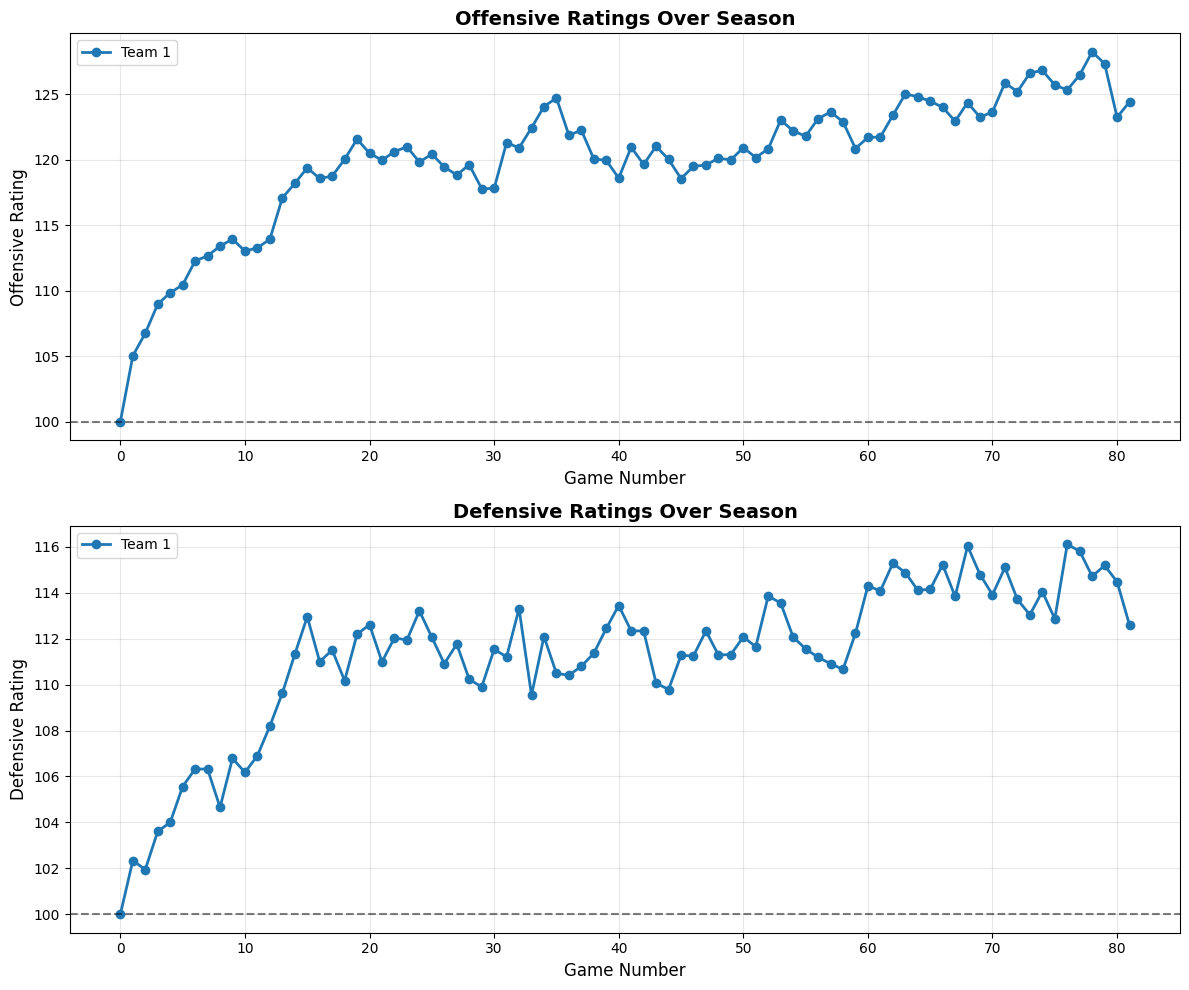

In [61]:
import matplotlib.pyplot as plt

def plot_team_ratings(ratings_df, *team_ids):
    """
    Plot offensive and defensive ratings over time for specified teams
    
    Args:
        ratings_df: DataFrame from build_team_ratings()
        *team_ids: Variable number of team IDs to plot
    
    Example:
        plot_team_ratings(ratings_df, 1)
        plot_team_ratings(ratings_df, 1, 2, 3)
    """
    if len(team_ids) == 0:
        print("Please provide at least one team ID")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    for team_id in team_ids:
        # Get home games
        home_games = ratings_df[ratings_df['home_team_id'] == team_id].copy()
        home_games['game_num'] = range(len(home_games))
        
        # Get away games
        away_games = ratings_df[ratings_df['away_team_id'] == team_id].copy()
        away_games['game_num'] = range(len(home_games), len(home_games) + len(away_games))
        
        # Combine all games in order
        all_home = home_games[['date', 'home_off_rating', 'home_def_rating']].copy()
        all_home.columns = ['date', 'off_rating', 'def_rating']
        all_home['game_num'] = range(len(all_home))
        
        all_away = away_games[['date', 'away_off_rating', 'away_def_rating']].copy()
        all_away.columns = ['date', 'off_rating', 'def_rating']
        all_away['game_num'] = range(len(all_home), len(all_home) + len(all_away))
        
        all_games = pd.concat([all_home, all_away]).sort_values('date').reset_index(drop=True)
        all_games['game_num'] = range(len(all_games))
        
        # Plot offensive rating
        ax1.plot(all_games['game_num'], all_games['off_rating'], 
                marker='o', label=f'Team {team_id}', linewidth=2)
        
        # Plot defensive rating
        ax2.plot(all_games['game_num'], all_games['def_rating'], 
                marker='o', label=f'Team {team_id}', linewidth=2)
    
    # Formatting
    ax1.set_title('Offensive Ratings Over Season', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Game Number', fontsize=12)
    ax1.set_ylabel('Offensive Rating', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='League Average (100)')
    
    ax2.set_title('Defensive Ratings Over Season', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Game Number', fontsize=12)
    ax2.set_ylabel('Defensive Rating', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='League Average (100)')
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_team_ratings(ratings_df, 1)           # Single team
# plot_team_ratings(ratings_df, 1, 2, 3)     # Multiple teams

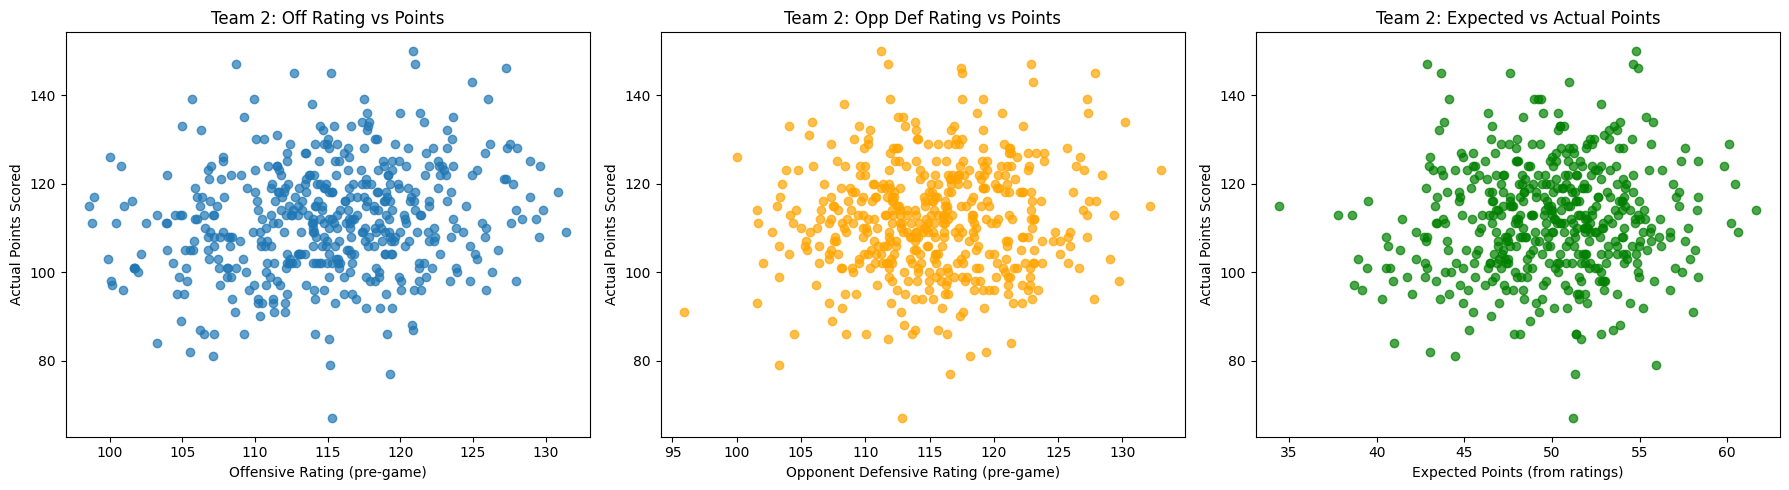

In [ ]:
import matplotlib.pyplot as plt

def plot_rating_vs_points(ratings_df, api_df, team_id):
    """
    Plot how well ratings explain actual points scored for a given team.
    """

    # Merge only points, not team IDs again
    merged = ratings_df.merge(
        api_df[["game_id", "home_pts", "away_pts"]],
        on="game_id", how="left"
    )

    # Filter for chosen team
    team_games = merged[
        (merged["home_team_id"] == team_id) | (merged["away_team_id"] == team_id)
    ].copy()

    # Actual points scored
    team_games["pts_scored"] = team_games.apply(
        lambda g: g["home_pts"] if g["home_team_id"] == team_id else g["away_pts"], axis=1
    )

    # Ratings
    team_games["off_rating"] = team_games.apply(
        lambda g: g["home_off_rating"] if g["home_team_id"] == team_id else g["away_off_rating"], axis=1
    )
    team_games["opp_def_rating"] = team_games.apply(
        lambda g: g["away_def_rating"] if g["home_team_id"] == team_id else g["home_def_rating"], axis=1
    )

    # Simple combined expected points
    team_games["expected_pts"] = (team_games["off_rating"] + (100 - team_games["opp_def_rating"])) / 2

    # ---- Plotting ----
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(team_games["off_rating"], team_games["pts_scored"], alpha=0.7)
    axes[0].set_title(f"Team {team_id}: Off Rating vs Points")
    axes[0].set_xlabel("Offensive Rating (pre-game)")
    axes[0].set_ylabel("Actual Points Scored")

    axes[1].scatter(team_games["opp_def_rating"], team_games["pts_scored"], alpha=0.7, color="orange")
    axes[1].set_title(f"Team {team_id}: Opp Def Rating vs Points")
    axes[1].set_xlabel("Opponent Defensive Rating (pre-game)")
    axes[1].set_ylabel("Actual Points Scored")

    axes[2].scatter(team_games["expected_pts"], team_games["pts_scored"], alpha=0.7, color="green")
    axes[2].set_title(f"Team {team_id}: Expected vs Actual Points")
    axes[2].set_xlabel("Expected Points (from ratings)")
    axes[2].set_ylabel("Actual Points Scored")

    plt.tight_layout()
    plt.show()
# Assuming your new api_df has 2019-2025 games
#alfa nie ma znaczenia - rating sam jest za slaby
ratings_df = build_team_ratings(df, alpha=0.3)  # use the updated api_df here

plot_rating_vs_points(ratings_df, df, team_id=2)
